# Experiment with Noise Scheduler

In [2]:
import os
from config import TrainingConfig, parse_arguments
from datamodule import OADATDataModule
from model import DiffusionModel
from utils import get_last_checkpoint
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint, ModelSummary
from lightning.pytorch.loggers import WandbLogger
from diffusers import DDIMScheduler

/myhome/micromamba/envs/oadatldm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


setup datamodule...


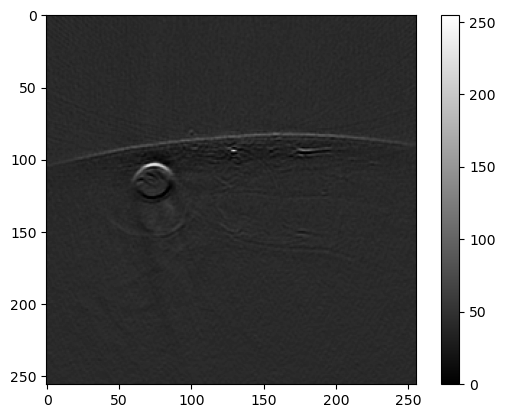

In [3]:
import matplotlib.pyplot as plt
import torch
from torchvision.transforms import ToPILImage
from diffusers import DDIMScheduler

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Set up data module
datamodule = OADATDataModule(
    data_path="/mydata/dlbirhoui/firat/OADAT", 
    batch_size=4, 
    num_workers=4
)
datamodule.setup(stage="fit")
# Set up configuration
config = TrainingConfig(
  num_epochs=5,
  batch_size=4
)
# 0, 50, 100, 150, ..., 1000 (21 timesteps)
clean_image = next(iter(datamodule.train_dataloader())).to(device)[3]
# show clean image and its color bar
plt.imshow(ToPILImage()(clean_image), cmap='gray')
plt.colorbar()
plt.show()

clean_images = clean_image.unsqueeze(0).repeat(21, 1, 1, 1)
torch.manual_seed(config.seed)
noises = torch.randn(clean_images.shape, device=device)
timesteps = torch.linspace(0, 999, steps=21, device=device, dtype=torch.int32)

adding noise...
plotting...


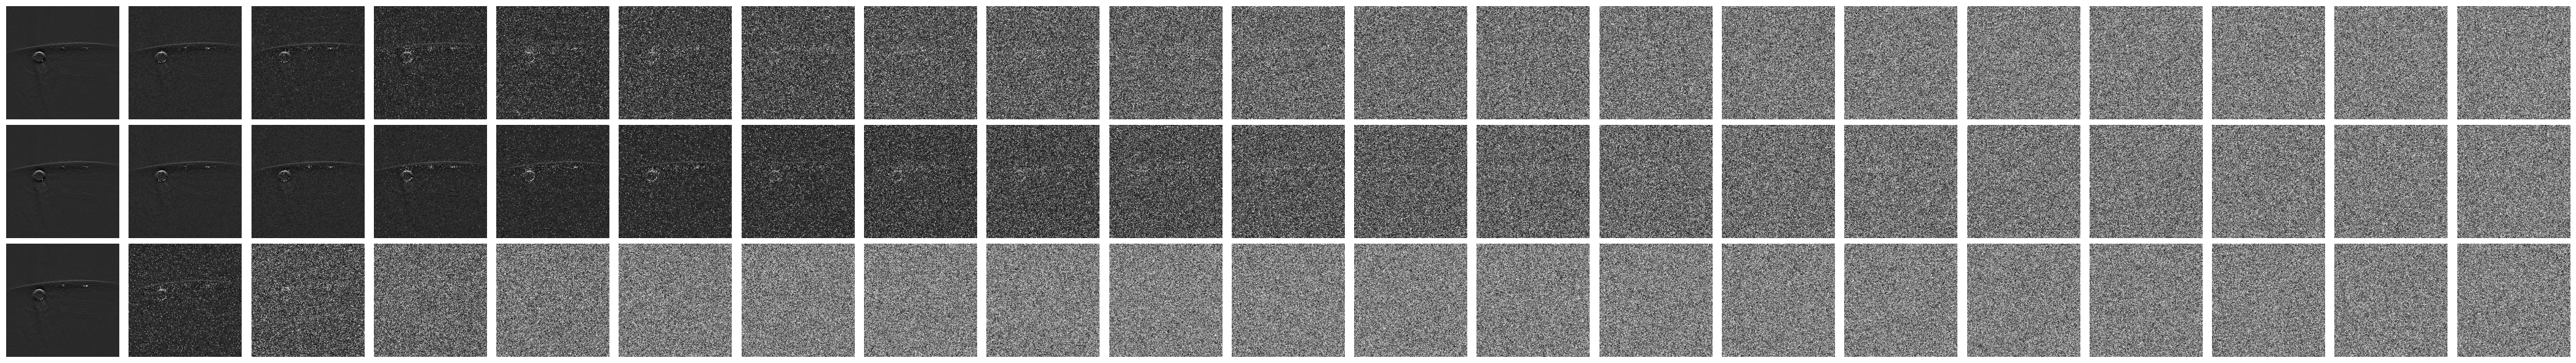

In [5]:
# With specifying beta_start and beta_end

# Define different schedulers
linear_noise_scheduler = DDIMScheduler(
    num_train_timesteps=1000,
    beta_start=1e-5,
    beta_end=5e-4,
    beta_schedule='linear'
)
scaled_noise_scheduler = DDIMScheduler(
    num_train_timesteps=1000,
    beta_start=1e-5,
    beta_end=5e-4,
    beta_schedule='scaled_linear'
)
squaredcos_noise_scheduler = DDIMScheduler(
    num_train_timesteps=1000,
    beta_start=1e-5,
    beta_end=5e-4,
    beta_schedule='squaredcos_cap_v2'
)

print('adding noise...')

# Generate noisy images for each scheduler
linear_noisy_images = linear_noise_scheduler.add_noise(clean_images, noises, timesteps)
scaled_noisy_images = scaled_noise_scheduler.add_noise(clean_images, noises, timesteps)
squaredcos_noisy_images = squaredcos_noise_scheduler.add_noise(clean_images, noises, timesteps)

# Convert tensors to PIL images
to_pil = ToPILImage()
pil_linear_noisy_images = [to_pil(image.cpu()) for image in linear_noisy_images]
pil_scaled_noisy_images = [to_pil(image.cpu()) for image in scaled_noisy_images]
pil_squaredcos_noisy_images = [to_pil(image.cpu()) for image in squaredcos_noisy_images]

# Create subplots with 3 rows (one for each scheduler) and 21 columns (one for each timestep)
fig, axes = plt.subplots(3, 21, figsize=(42, 6))  # 3 rows, 21 columns, adjust figsize as needed

# Display images in the subplots
print('plotting...')
for i in range(21):
    # First row: scaled_linear schedule
    axes[0, i].imshow(pil_linear_noisy_images[i], cmap='gray')
    axes[0, i].axis('off')

    # Second row: linear schedule
    axes[1, i].imshow(pil_scaled_noisy_images[i], cmap='gray')
    axes[1, i].axis('off')

    # Third row: squaredcos schedule
    axes[2, i].imshow(pil_squaredcos_noisy_images[i], cmap='gray')
    axes[2, i].axis('off')


plt.tight_layout()
plt.show()


tensor([[-3.0000, -2.9765, -2.9529, -2.9294, -2.9059, -2.8824, -2.8588, -2.8353,
         -2.8118, -2.7882, -2.7647, -2.7412, -2.7176, -2.6941, -2.6706, -2.6471],
        [-2.6235, -2.6000, -2.5765, -2.5529, -2.5294, -2.5059, -2.4824, -2.4588,
         -2.4353, -2.4118, -2.3882, -2.3647, -2.3412, -2.3176, -2.2941, -2.2706],
        [-2.2471, -2.2235, -2.2000, -2.1765, -2.1529, -2.1294, -2.1059, -2.0824,
         -2.0588, -2.0353, -2.0118, -1.9882, -1.9647, -1.9412, -1.9176, -1.8941],
        [-1.8706, -1.8471, -1.8235, -1.8000, -1.7765, -1.7529, -1.7294, -1.7059,
         -1.6824, -1.6588, -1.6353, -1.6118, -1.5882, -1.5647, -1.5412, -1.5176],
        [-1.4941, -1.4706, -1.4471, -1.4235, -1.4000, -1.3765, -1.3529, -1.3294,
         -1.3059, -1.2824, -1.2588, -1.2353, -1.2118, -1.1882, -1.1647, -1.1412],
        [-1.1176, -1.0941, -1.0706, -1.0471, -1.0235, -1.0000, -0.9765, -0.9529,
         -0.9294, -0.9059, -0.8824, -0.8588, -0.8353, -0.8118, -0.7882, -0.7647],
        [-0.7412, -0.7

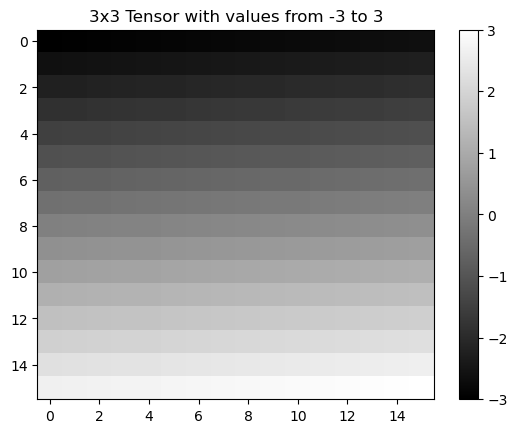

In [10]:
import torch
import matplotlib.pyplot as plt

# Create a 3x3 tensor with values from -3 to 3
tensor = torch.linspace(-3, 3, steps=256).reshape(16, 16)
print(tensor)

# Plot the tensor with colorbar
plt.imshow(tensor.numpy(), cmap='gray', aspect='auto')
plt.colorbar()
plt.title('16x16 Tensor with values from -3 to 3')
plt.show()


In [13]:
from torchvision.transforms import v2
clamp_tensor = torch.clamp(tensor, 0, 1)

pil_tensor = v2.ToPILImage()(clamp_tensor)
pil_tensor

In [14]:
pil_tensor.save('./pil_tensor_clamp.png')

In [16]:
import torch
import matplotlib.pyplot as plt

tensor = torch.linspace(-4, 4, steps=9).reshape(3, 3)
tensor = torch.clamp(tensor, 0, 1)
plt.figure()
plt.imshow(tensor.numpy(), cmap='gray', aspect='auto')
plt.colorbar()  # Add colorbar to the plot

# Save the plot (including the colorbar) as an image
plt.savefig('tensor_with_colorbar.png', bbox_inches='tight')  # Save with tight layout to include everything
plt.close()


In [6]:
import torch
import matplotlib.pyplot as plt

# Create multiple 3x3 tensors with values from -3 to 3 for example
tensors = [torch.linspace(-3, 3, steps=9).reshape(3, 3) for _ in range(10)]  # Example with 3 tensors

# Create a figure with subplots arranged in a 1xN grid (1 row, N columns)
num_images = len(tensors)
fig, axs = plt.subplots(1, num_images, figsize=(num_images * 5, 5))  # Adjust figsize based on number of images

# Plot each tensor in its own subplot
for i, tensor in enumerate(tensors):
    ax = axs[i] if num_images > 1 else axs  # If only one image, axs won't be an array
    im = ax.imshow(tensor.numpy(), cmap='gray', aspect='equal')
    ax.axis('off')  # Turn off the axis
    fig.colorbar(im, ax=ax)  # Add colorbar to each subplot

# Save the combined plot locally
local_image_path = 'combined_tensor_plots.png'
plt.savefig(local_image_path, bbox_inches='tight')
plt.close()
